In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import os
import pickle
from skimage.transform import rescale, rotate
import noise
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import sys
sys.path.insert(1, os.getcwd()+"/../..") # Not needed if you installed SyMBac using pip
from SyMBac.drawing import raster_cell
from SyMBac.colony_simulation import ColonySimulation

#Remove directory data if it exists
if os.path.exists("data"):
    os.system("rm -rf data")

In [51]:
colonysim = ColonySimulation(
    cellmodeller_model= 'cellmodeller_ex1_simpleGrowth_modified.py',
    max_cells = 7,
    pix_mic_conv = 0.03,
    resize_amount = 3,
    save_dir = "dx_test/",
)

colonysim.run_cellmodeller_sim(num_sim=1)
colonysim.get_simulation_dirs()
pickles = colonysim.get_simulation_pickles()
colonysim.get_max_scene_size()

FRAME_CNT = len(pickles[-1])

Creating directory data/dx_test/
Set up OpenCL context:
  Platform: NVIDIA CUDA
  Device: NVIDIA GeForce GTX 1650
Importing model cellmodeller_ex1_simpleGrowth_modified
      10           2 cells           0 contacts    0.000022 hour(s) or 0.001340 minute(s) or 0.080408 second(s)
      20           2 cells           0 contacts    0.000035 hour(s) or 0.002113 minute(s) or 0.126762 second(s)
      30           2 cells           0 contacts    0.000048 hour(s) or 0.002884 minute(s) or 0.173055 second(s)
      40           2 cells           0 contacts    0.000061 hour(s) or 0.003685 minute(s) or 0.221095 second(s)
   40     2 cells       1 cts       1 iterations  residual = 0.001000
      50           3 cells           2 contacts    0.000097 hour(s) or 0.005793 minute(s) or 0.347604 second(s)
   50     3 cells       2 cts       3 iterations  residual = 0.001378
      60           3 cells           2 contacts    0.000134 hour(s) or 0.008016 minute(s) or 0.480950 second(s)
   60     4 cells  

In [52]:
colonysim.draw_simulation_OPL(n_jobs = 1, FL=True, density = 0.1, random_distribution = "uniform", distribution_args = (0.9, 3))

Scene Draw:: 0it [00:00, ?it/s]

/home/boomalope/anaconda3/envs/symbac/SyMBac/tests/dx_test_env/../../SyMBac/drawing.py:474: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return remove_small_objects(label(mask))


In [53]:
from SyMBac.colony_renderer import ColonyRenderer
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

from skimage.exposure import rescale_intensity


/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

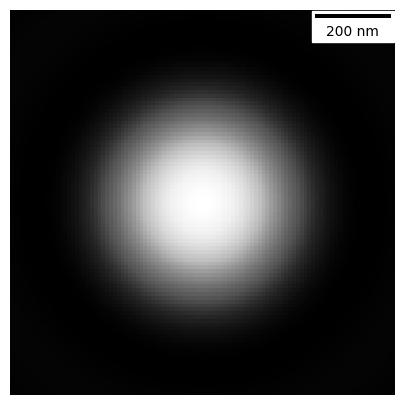

In [54]:
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.45, 
    n = 1.4, 
    resize_amount = colonysim.resize_amount, 
    pix_mic_conv = colonysim.pix_mic_conv, 
    apo_sigma = 8, 
    mode="simple fluo", 
    condenser = "Ph3",
    offset = 0.02
)

my_kernel.calculate_PSF()
my_kernel.plot_PSF()

/home/boomalope/anaconda3/envs/symbac/SyMBac/tests/dx_test_env/../../SyMBac/PSF.py:178: RuntimeWarning: invalid value encountered in divide
  PSF = (2 * jv(1, rr) / (rr)) ** 2


/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

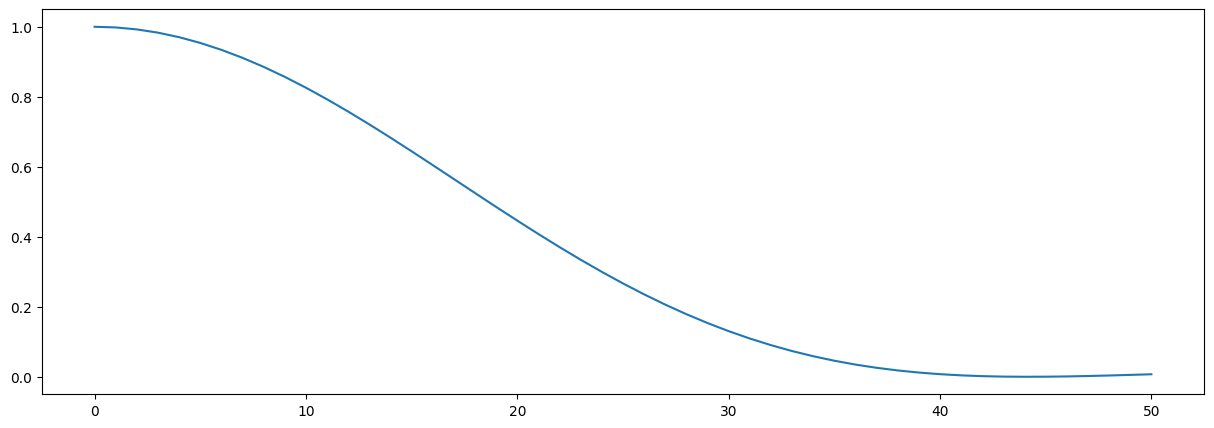

In [55]:
psf = my_kernel.get_fluorescence_kernel(my_kernel.wavelength,my_kernel.NA,my_kernel.n,my_kernel.radius,my_kernel.scale)
size = psf.shape[1]
central_psf = psf[psf.shape[1]//2]
central_psf = central_psf[len(central_psf)//2:]
plt.plot(central_psf)


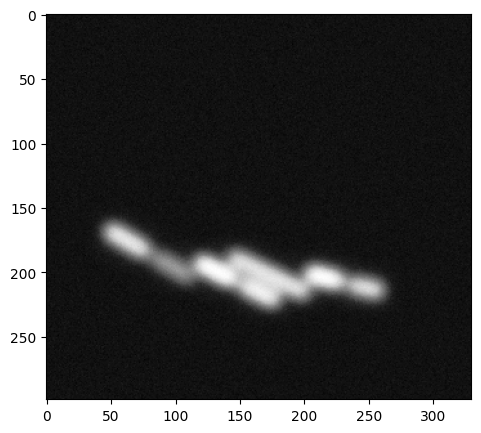

In [56]:
my_renderer = ColonyRenderer(colonysim, my_kernel)
test_img = my_renderer.render_scene(-1)
mask = my_renderer.mask_loader(-1)
plt.imshow(test_img, cmap="Greys_r")

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

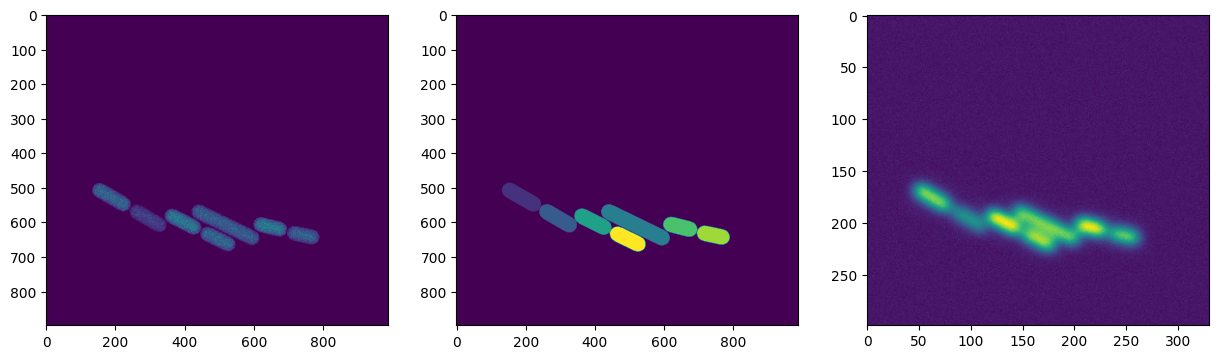

In [58]:
import os

PATH = os.getcwd()
original = mpimg.imread(PATH + '/data/scenes/00{frame}.png'.format(frame=FRAME_CNT))
mask = mpimg.imread(PATH + '/data/masks/00{frame}.png'.format(frame=FRAME_CNT))    

#original = NormalizeData(original)
#mask = NormalizeData(mask)
#test_img = NormalizeData(test_img)
f, axarr = plt.subplots(1,3)
axarr[0].plot(100,100)
axarr[0].imshow(original)
axarr[1].imshow(mask)
axarr[2].imshow(test_img)
plt.show()

In [59]:
with open('ori.pkl', 'wb') as file: 
    pickle.dump(original, file)
with open('mask.pkl', 'wb') as file: 
    pickle.dump(mask, file)
with open('out.pkl', 'wb') as file: 
    pickle.dump(test_img, file)
with open('psf.pkl', 'wb') as file: 
    pickle.dump(psf, file)